# Klassifikations-Modell

In [64]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [29]:
data = pd.DataFrame({
    'temperature': [2, 3, 5, 5, 8, 9, 10, 11, 11, 14, 16, 18, 20, 20, 21, 21, 22, 26, 28, 29],
    'humidity': [0.01, 0.92, 0.74, 0.96, 0.01, 0.22, 0.48, 0.98, 0.79, 0.81, 0.13,
       0.85, 0.94, 0.41, 0.23, 0.39, 0.15, 0.57, 0.87, 0.36],
    'pollen': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
})

In [30]:
data

,temperature,humidity,pollen
0,2,0.01,0
1,3,0.92,0
2,5,0.74,0
3,5,0.96,0
4,8,0.01,1
5,9,0.22,0
6,10,0.48,0
7,11,0.98,0
8,11,0.79,0
9,14,0.81,0


<Axes: xlabel='humidity', ylabel='temperature'>

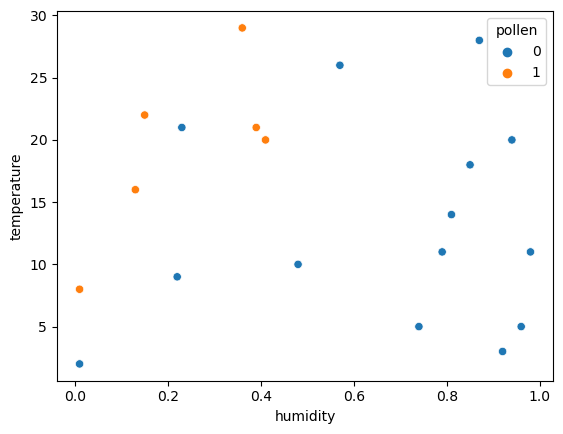

In [31]:
sns.scatterplot(data, x='humidity', y='temperature', hue='pollen')

In [57]:
feature_matrix = data[['temperature', 'humidity']]
target = data.pollen
train_feature_matrix, test_feature_matrix, train_y, test_y = train_test_split(feature_matrix, target, test_size=0.4, random_state=2)

In [59]:
model = LogisticRegression()
model.fit(train_feature_matrix, train_y)

LogisticRegression()

In [60]:
model.predict_proba(test_feature_matrix)

array([[0.63393392, 0.36606608],
       [0.95962641, 0.04037359],
       [0.19152028, 0.80847972],
       [0.99045208, 0.00954792],
       [0.87833889, 0.12166111],
       [0.95242877, 0.04757123],
       [0.98579499, 0.01420501],
       [0.77661109, 0.22338891]])

In [61]:
predictions = model.predict(test_feature_matrix)

In [62]:
accuracy_score(test_y, predictions)

0.625

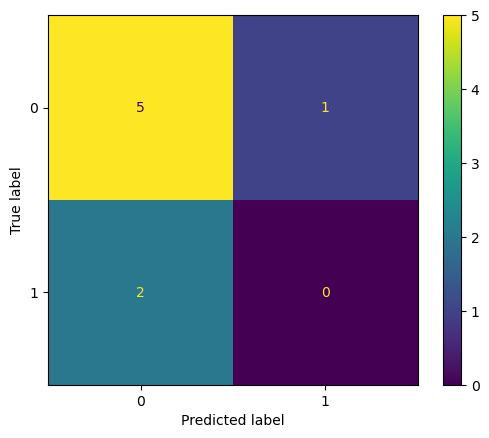

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix(test_y, predictions))
disp.plot()